In [697]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms

from statsmodels.stats.proportion import proportions_ztest
from tqdm import tqdm

In [796]:
# Сделаем имитацию AB-теста. Для этого сгенерируем a и b выборки с биномиальным распределением:
# binomial(случайно выпадающее значение, вероятность, размер)
a = np.random.binomial(1, 0.03, size=1000)
b = np.random.binomial(1, 0.032, size=1000)

In [797]:
print(a.mean())
print(b.mean())

0.031
0.033


In [798]:
# Посчитаем T статистики
stat, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
print('Результат теста', stat)
print('P-value', pval)

Результат теста -0.2540986338067945
P-value 0.7994193588060443


In [799]:
# P-value > 0.05. Можем сделать вывод, что статистически значимых различий между средними двух выборок нет.
# Вероятность получить такие и большие различия, когда их реально нет составляет 0.67
t_test_result = stats.ttest_ind(a, b, equal_var=False)
print('Результат теста', t_test_result.statistic)
print('P-value', t_test_result.pvalue)

Результат теста -0.2539756523000959
P-value 0.7995405249613179


In [800]:
a = pd.Series(a)
b = pd.Series(b)
ab_result = pd.DataFrame([a.describe(), b.describe()], index=['a', 'b'])

In [801]:
ab_result['se'] = stats.sem(a), stats.sem(b)
ab_result['margin'] = 1.96 * ab_result['se']
ab_result['95 low'] = ab_result['mean'] - abs(ab_result['margin'])
ab_result['95 high'] = ab_result['mean'] + abs(ab_result['margin'])
ab_result

,count,mean,std,min,25%,50%,75%,max,se,margin,95 low,95 high
a,1000.0,0.031,0.173404,0.0,0.0,0.0,0.0,1.0,0.005484,0.010748,0.020252,0.041748
b,1000.0,0.033,0.178726,0.0,0.0,0.0,0.0,1.0,0.005652,0.011078,0.021922,0.044078


95% доверительный интервал для A выборки
0.0203 - 0.0417
95% доверительный интервал для B выборки
0.0219 - 0.0441


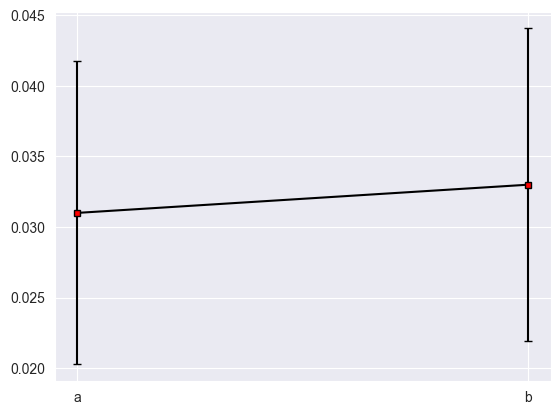

In [802]:
plt.errorbar(x=ab_result.index, y=ab_result['mean'], yerr=ab_result['margin'], color="black",
             capsize=3, marker="s", markersize=4, mfc="red", mec="black")
print('95% доверительный интервал для A выборки')
print(round(ab_result.at['a', '95 low'], 4), '-' ,round(ab_result.at['a', '95 high'], 4))
print('95% доверительный интервал для B выборки')
print(round(ab_result.at['b', '95 low'], 4), '-' ,round(ab_result.at['b', '95 high'], 4))
plt.show()

In [803]:
# При такой разнице в конверсии, чтобы получить статистически значимые различия, необходимо увеличивать размер выборок.

In [804]:
es = sms.proportion_effectsize(a.mean(), b.mean())
size = sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1)
round(size)

121534

In [815]:
# Слишком долго ждать, чтобы набрать такое количество наблюдений. Решим задачу с помощью Bootstrap:
# 1. Будем создавать подвыборки с помощью метода np.random.choice(), который случайный образом дергаем наблюдения.
# (источник наблюдений, размер подвыборки (делаем равным инитной выборке, чтобы оценка стандартного отклонения была несмещённой),
# True — возвращаем наблюдения, одно и то же наблюдение может использоваться много раз.
# 2. Считаем интересующий нас показатель статистики (в данном случае среднее значение). Сохраняем значение
# 3. Повторяем 10 000 раз п.1-п.2. Рекомендуется от 1000 и больше.

a_bootstrap_mean = []
b_bootstrap_mean = []
for _ in tqdm(range(10000)):
    a_bootstrap = np.random.choice(a, len(a), True)
    b_bootstrap = np.random.choice(b, len(b), True)
    a_bootstrap_mean.append(pd.Series(a_bootstrap).mean())
    b_bootstrap_mean.append(pd.Series(b_bootstrap).mean())

100%|██████████| 10000/10000 [00:03<00:00, 2624.85it/s]


In [817]:
bootstrap_result = pd.DataFrame({'a': a_bootstrap_mean, 'b': b_bootstrap_mean})

In [818]:
t_test_result = stats.ttest_ind(a_bootstrap_mean, b_bootstrap_mean, equal_var=False)
print('Результат теста', t_test_result.statistic)
print('P-value', t_test_result.pvalue)

Результат теста -26.966370225643473
P-value 2.3925038963693485e-157


In [808]:
a_bootstrap_mean = pd.Series(a_bootstrap_mean)
b_bootstrap_mean = pd.Series(b_bootstrap_mean)
bootstrap_summary = pd.DataFrame([a_bootstrap_mean.describe(), b_bootstrap_mean.describe()], index=['a', 'b'])
bootstrap_summary['se'] = stats.sem(a_bootstrap_mean), stats.sem(a_bootstrap_mean)
bootstrap_summary['margin'] = 1.96 * bootstrap_summary['se']
bootstrap_summary['95 low'] = bootstrap_summary['mean'] - abs(bootstrap_summary['margin'])
bootstrap_summary['95 high'] = bootstrap_summary['mean'] + abs(bootstrap_summary['margin'])
bootstrap_summary

,count,mean,std,min,25%,50%,75%,max,se,margin,95 low,95 high
a,10000.0,0.030906,0.005441,0.015,0.027,0.031,0.035,0.053,0.000054,0.000107,0.030800,0.031013
b,10000.0,0.032933,0.005642,0.015,0.029,0.033,0.037,0.056,0.000054,0.000107,0.032827,0.033040


95% доверительный интервал для A выборки
0.0308 - 0.031
95% доверительный интервал для B выборки
0.0328 - 0.033
P-value 4.3106394997444156e-145


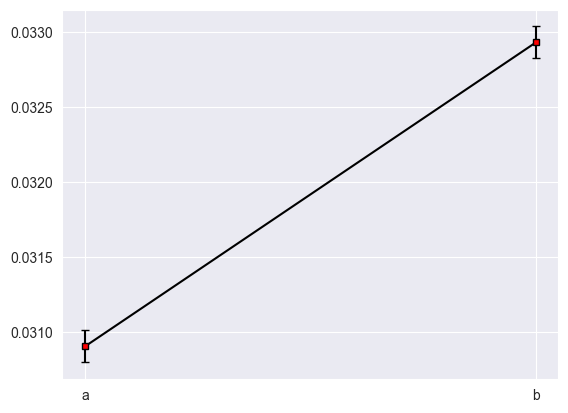

In [809]:
plt.errorbar(x=bootstrap_summary.index, y=bootstrap_summary['mean'], yerr=bootstrap_summary['margin'], color="black",
             capsize=3, marker="s", markersize=4, mfc="red", mec="black")
print('95% доверительный интервал для A выборки')
print(round(bootstrap_summary.at['a', '95 low'], 4), '-' ,round(bootstrap_summary.at['a', '95 high'], 4))
print('95% доверительный интервал для B выборки')
print(round(bootstrap_summary.at['b', '95 low'], 4), '-' ,round(bootstrap_summary.at['b', '95 high'], 4))
print('P-value', t_test_result.pvalue)
plt.show()

In [767]:
# Благодаря bootstrap мы смогли получить статистически значимые результаты без увеличения размера выборки

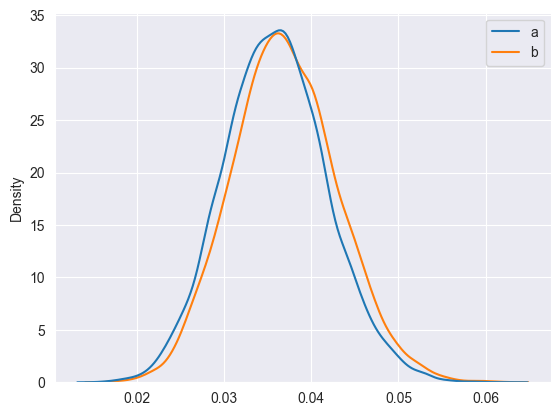

In [768]:
# На сладкое
sns.kdeplot(bootstrap_result)
plt.show()

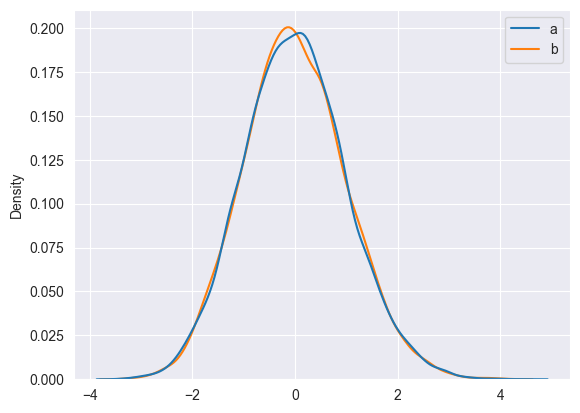

In [769]:
# В стандартной шкале
a_z_score = stats.zscore(a_bootstrap_mean)
b_z_score = stats.zscore(b_bootstrap_mean)
sns.kdeplot(pd.DataFrame({'a': a_z_score, 'b':b_z_score}))
plt.show()

In [832]:
# Попробуем на реальных данных
# 100 samples with 700 observations in each
data_frame = pd.read_csv('/Users/mitya/Downloads/cr_export.csv', sep=',', header=None)
bounce_rate = data_frame[0]
page_view = data_frame[1]
conversion_rate_100 = data_frame[2]
cr_all_forms = data_frame[3]

# 100 samples with 10 000 observations in each
data_frame_1 = pd.read_csv('/Users/mitya/Downloads/cr_export_1.csv', sep=',', header=None)
bounce_rate_1 = data_frame_1[0]
page_view_1 = data_frame_1[1]

# 500 samples with ~ 700 observations in each
data_frame_2 = pd.read_csv('/Users/mitya/Downloads/cr_export_2.csv', sep=',', header=None)
bounce_rate_2 = data_frame_2[0]
print(data_frame.shape)
print(data_frame_1.shape)
print(data_frame_2.shape)

(101, 4)
(101, 2)
(505, 2)


### Conversion Rate AA test

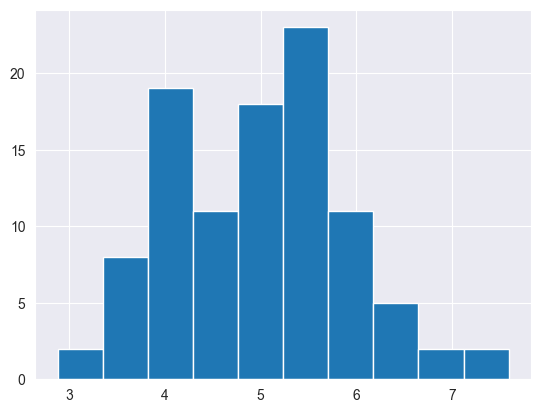

In [870]:
cr_all_forms.hist()
plt.show()

In [871]:
cr_all_forms.describe()

count    101.000000
mean       4.993564
std        0.929552
min        2.880000
25%        4.220000
50%        4.990000
75%        5.640000
max        7.590000
Name: 3, dtype: float64

In [882]:
a_bootstrap_mean = []
b_bootstrap_mean = []
for _ in tqdm(range(10000)):
    a_bootstrap = np.random.choice(cr_all_forms, len(cr_all_forms), True)
    b_bootstrap = np.random.choice(cr_all_forms, len(cr_all_forms), True)
    a_bootstrap_mean.append(pd.Series(a_bootstrap).mean())
    b_bootstrap_mean.append(pd.Series(b_bootstrap).mean())

100%|██████████| 10000/10000 [00:03<00:00, 2932.56it/s]


In [883]:
bootstrap_result = pd.DataFrame({'a': a_bootstrap_mean, 'b': b_bootstrap_mean})

In [884]:
t_test_result = stats.ttest_ind(a_bootstrap_mean, b_bootstrap_mean, equal_var=False)
print('Результат теста', t_test_result.statistic)
print('P-value', t_test_result.pvalue)

Результат теста 0.8142426634744666
P-value 0.415515646684373


In [885]:
a_bootstrap_mean = pd.Series(a_bootstrap_mean)
b_bootstrap_mean = pd.Series(b_bootstrap_mean)
bootstrap_summary = pd.DataFrame([a_bootstrap_mean.describe(), b_bootstrap_mean.describe()], index=['a', 'b'])
bootstrap_summary['se'] = stats.sem(a_bootstrap_mean), stats.sem(a_bootstrap_mean)
bootstrap_summary['margin'] = 1.96 * bootstrap_summary['se']
bootstrap_summary['95 low'] = bootstrap_summary['mean'] - abs(bootstrap_summary['margin'])
bootstrap_summary['95 high'] = bootstrap_summary['mean'] + abs(bootstrap_summary['margin'])
bootstrap_summary

,count,mean,std,min,25%,50%,75%,max,se,margin,95 low,95 high
a,10000.0,4.994920,0.093027,4.653465,4.932822,4.994752,5.057525,5.371386,0.00093,0.001823,4.993096,4.996743
b,10000.0,4.993856,0.091637,4.635347,4.932772,4.993020,5.055347,5.368317,0.00093,0.001823,4.992033,4.995680


95% доверительный интервал для A выборки
4.9931 - 4.9967
95% доверительный интервал для B выборки
4.992 - 4.9957
P-value 0.415515646684373


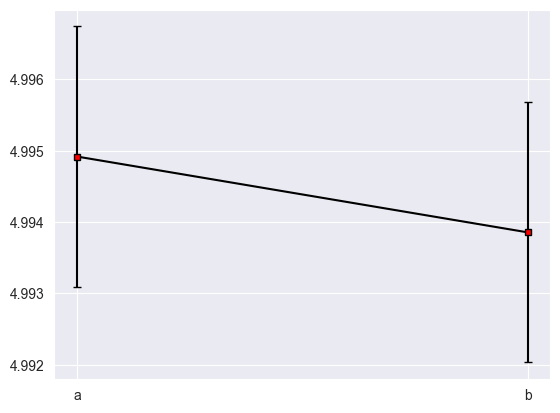

In [886]:
plt.errorbar(x=bootstrap_summary.index, y=bootstrap_summary['mean'], yerr=bootstrap_summary['margin'], color="black",
             capsize=3, marker="s", markersize=4, mfc="red", mec="black")
print('95% доверительный интервал для A выборки')
print(round(bootstrap_summary.at['a', '95 low'], 4), '-' ,round(bootstrap_summary.at['a', '95 high'], 4))
print('95% доверительный интервал для B выборки')
print(round(bootstrap_summary.at['b', '95 low'], 4), '-' ,round(bootstrap_summary.at['b', '95 high'], 4))
print('P-value', t_test_result.pvalue)
plt.show()

### Conversion Rate AB-test

In [855]:
a_bootstrap_mean = []
b_bootstrap_mean = []
for _ in tqdm(range(10000)):
    a_bootstrap = np.random.choice(conversion_rate_100, len(conversion_rate_100), True)
    b_bootstrap = np.random.choice(conversion_rate_100 + 0.01, len(conversion_rate_100), True)
    a_bootstrap_mean.append(pd.Series(a_bootstrap).mean())
    b_bootstrap_mean.append(pd.Series(b_bootstrap).mean())

100%|██████████| 10000/10000 [00:04<00:00, 2147.06it/s]


In [856]:
bootstrap_result = pd.DataFrame({'a': a_bootstrap_mean, 'b': b_bootstrap_mean})

In [857]:
t_test_result = stats.ttest_ind(a_bootstrap_mean, b_bootstrap_mean, equal_var=False)
print('Результат теста', t_test_result.statistic)
print('P-value', t_test_result.pvalue)

Результат теста -21.799137512757287
P-value 3.852523183531222e-104


In [858]:
a_bootstrap_mean = pd.Series(a_bootstrap_mean)
b_bootstrap_mean = pd.Series(b_bootstrap_mean)
bootstrap_summary = pd.DataFrame([a_bootstrap_mean.describe(), b_bootstrap_mean.describe()], index=['a', 'b'])
bootstrap_summary['se'] = stats.sem(a_bootstrap_mean), stats.sem(a_bootstrap_mean)
bootstrap_summary['margin'] = 1.96 * bootstrap_summary['se']
bootstrap_summary['95 low'] = bootstrap_summary['mean'] - abs(bootstrap_summary['margin'])
bootstrap_summary['95 high'] = bootstrap_summary['mean'] + abs(bootstrap_summary['margin'])
bootstrap_summary

,count,mean,std,min,25%,50%,75%,max,se,margin,95 low,95 high
a,10000.0,0.692300,0.03324,0.578614,0.669802,0.691683,0.715050,0.823465,0.000332,0.000652,0.691648,0.692951
b,10000.0,0.702567,0.03337,0.584158,0.679604,0.702376,0.724554,0.831980,0.000332,0.000652,0.701916,0.703219


95% доверительный интервал для A выборки
0.6916 - 0.693
95% доверительный интервал для B выборки
0.7019 - 0.7032
P-value 3.852523183531222e-104


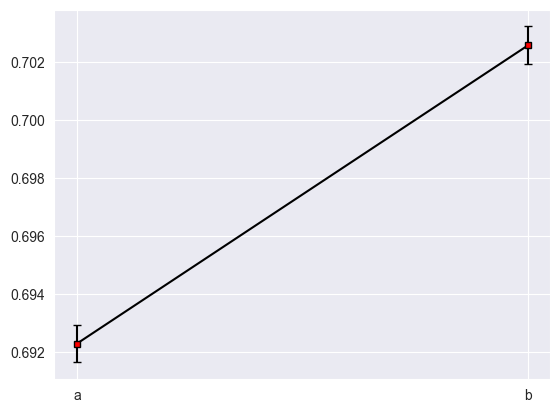

In [859]:
plt.errorbar(x=bootstrap_summary.index, y=bootstrap_summary['mean'], yerr=bootstrap_summary['margin'], color="black",
             capsize=3, marker="s", markersize=4, mfc="red", mec="black")
print('95% доверительный интервал для A выборки')
print(round(bootstrap_summary.at['a', '95 low'], 4), '-' ,round(bootstrap_summary.at['a', '95 high'], 4))
print('95% доверительный интервал для B выборки')
print(round(bootstrap_summary.at['b', '95 low'], 4), '-' ,round(bootstrap_summary.at['b', '95 high'], 4))
print('P-value', t_test_result.pvalue)
plt.show()

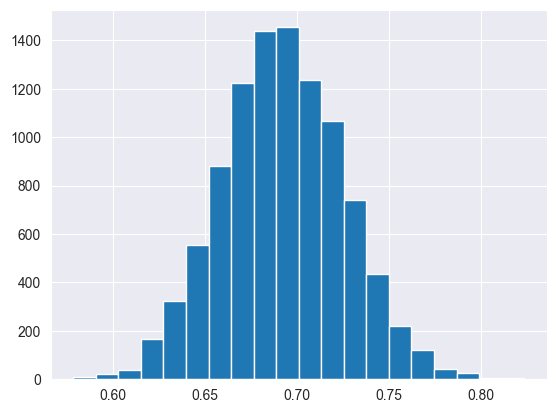

In [865]:
a_bootstrap_mean.hist(bins=20)
plt.show()